<a href="https://colab.research.google.com/github/TiphaineV/gpeg/blob/heavy/Graph_small_(working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Files

In [2]:
import pandas as pd
from sklearn.metrics import classification_report
import scipy.sparse as sparse

In [3]:
!pip install memory-profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp36-none-any.whl size=30181 sha256=0a9f7981890347003c66580a3f9d3f3ebd2252a018faa925fccbbbf5ca956b90
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built memory-profiler


In [4]:
%load_ext memory_profiler

In [5]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

KeyboardInterrupt: ignored

In [ ]:
userfile_id = '1SujkUIqpPKg9LlJ8s77upbeTKkenmrLc'
userMovieFile_id = '1Os5MhtWx-FRzyMYoh_QU_OWdRdzJH1_o'
adjency_id = '1Oz8rbp1HOb9EB_7dZYLQdVJ09oAyMlWB'

In [6]:
# -- some cleaning
needed = True
if needed :
  %rm -R gpeg/
  %rm context.py
  %rm fastGraph.py
  %rm node.py
  %rm _recSystems.py
  %rm trivialClf.py
  %rm edge.py
  %rm main.py 
  %rm scorer.py

rm: cannot remove 'gpeg/': No such file or directory
rm: cannot remove 'context.py': No such file or directory
rm: cannot remove 'fastGraph.py': No such file or directory
rm: cannot remove 'node.py': No such file or directory
rm: cannot remove '_recSystems.py': No such file or directory
rm: cannot remove 'trivialClf.py': No such file or directory
rm: cannot remove 'edge.py': No such file or directory
rm: cannot remove 'main.py': No such file or directory
rm: cannot remove 'scorer.py': No such file or directory


In [7]:
!git clone -b heavy https://github.com/TiphaineV/gpeg.git

Cloning into 'gpeg'...
remote: Enumerating objects: 330, done.
remote: Counting objects: 100% (330/330), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 496 (delta 223), reused 202 (delta 117), pack-reused 166
Receiving objects: 100% (496/496), 1.07 MiB | 3.50 MiB/s, done.
Resolving deltas: 100% (311/311), done.


In [ ]:
cd gpeg/fast_implementation/

/content/gpeg/fast_implementation


In [ ]:
# Modules
import numpy as np
from _recSystems import _Clf
from fastGraph import Graph
from trivialClf import TrivialClf
from scorer import ClfScorer

In [ ]:
# -- Loading userData (heavy, takes around a minute)
downloaded = drive.CreateFile({'id':userfile_id}) 
downloaded.GetContentFile('userData.csv')
#userDataStream = pd.read_csv('userData.csv', chunksize= 1e6) # please don't change chuksize

In [ ]:
# -- Loading userMovieData (heavy)
downloaded = drive.CreateFile({'id':userMovieFile_id}) 
downloaded.GetContentFile('userMovieData.csv')

In [ ]:
# -- Loading adjency 
downloaded = drive.CreateFile({'id':adjency_id}) 
downloaded.GetContentFile('adjency-20M.npz')

##Graph definition

In [5]:
'''
Builds the graph quickly
'''
#%% Modules
#standard
from abc import ABC, abstractmethod
import time
import numpy as np
import numpy.random as rd
import scipy.sparse as sparse
import pandas as pd



#%% FastGraph class
class Graph:
    def __init__(self, userData = None, nChunk= 5, chunksize= int(1e6), path= None):
        '''
        Parameters
        --------
        size: str
            'small' (100K), 'heavy' (20M)
        '''
        # -- IO
        print('Graph init ...')
        if path != None:
            self.load_adjency(path)
        # -- Attributes
        if path == None:
            self.set_adjency(userData, nChunk= nChunk, chunksize= chunksize)

        self.rowFormat = sparse.csr_matrix(self.adjency)
        self.colFormat = sparse.csc_matrix(self.adjency)
        pass

    def get_user(self, userId: int):
        return self.rowFormat[userId]

    def get_movie(self, movieId: int):
        return self.colFormat[:,movieId]

    def load_adjency(self, path):
        try:
            self.adjency = sparse.load_npz(path)
            self.edges = self.adjency.data

        except FileNotFoundError:
            print("file was not found, please try again or provide userData")
            raise
        pass

    def save_adjency(self, fileName):
        sparse.save_npz(fileName, self.adjency)
        pass


    def set_adjency(self, userData, nChunk= np.inf, chunksize= int(1e6)):
        ''''''
        # -- Builds the matrix
        rows = []
        cols = []
        data = []
        for k,chunk in enumerate(userData):
            print('Processing chunk {}.'.format(k))
            for idx in range(len(chunk)):
                # -- keys : userId, movieId.
                row = chunk.iloc[idx]
                # -- getting ids
                userId, movieId= row['userId'], row['movieId']

                # -- updating rows, cols, data
                rows.append(userId)
                cols.append(movieId)
                data.append(k*chunksize+idx)

            #### temp ####
            if k == nChunk - 1:
                break

        adjency = sparse.coo_matrix((data, (rows, cols)), shape=(int(max(rows))+1, int(max(cols))+1))

        self.adjency = adjency
        self.edges = adjency.data
        pass

    def train_test_split(self, alpha: float):
        '''
        '''
        # -- Checking parameter alpha
        if alpha >= 1 or alpha <=0 or not(isinstance(alpha,float)):
            raise ValueError('alpha must be a float in ]0,1[')

        # -- Parameters
        edges = self.edges
        n = len(edges)
        nTest = int(alpha * n)
        indexes = list(range(n))

        # -- Randomizing data
        rd.shuffle(indexes)

        # -- Getting the split
        idxTrain, idxTest = sorted(indexes[nTest:]), sorted(indexes[:nTest])
        nTrain, nTest = len(idxTrain), len(idxTest)

        return edges[idxTrain], edges[idxTest]

if __name__ == '__main__':
    pass

In [6]:
# -- Graph construction, nChunk * 1e6 rows are processed from movieLens 20M.
# -- Takes around 2'30 for one chunk
#%memit graph = Graph(path = 'adjency-20M.npz')
userMovieData_byChunk = pd.read_csv('userMovieData.csv', chunksize= int(1e6))
graph = Graph(userMovieData_byChunk)

Graph init ...
Processing chunk 0.


In [258]:
%%time
# -- Split
# -- Parameters
alpha = 0.3 # test proportion in the split

# -- train_test_split
%memit trainEdges, testEdges = graph.train_test_split(alpha= alpha)

peak memory: 490.88 MiB, increment: 2.70 MiB
CPU times: user 229 ms, sys: 26.2 ms, total: 256 ms
Wall time: 383 ms


## Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

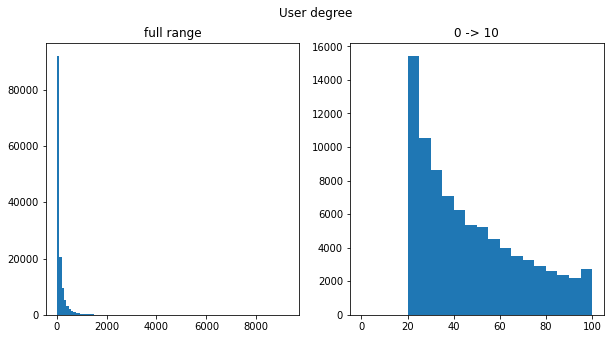

In [ ]:
n = graph.rowFormat.shape[0]
degreeDist = [graph.rowFormat[i].nnz for i in range(1,n)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('User degree')
ax1.hist(degreeDist, bins= 100)
ax1.set_title('full range')
ax2.hist(degreeDist, bins = 20, range=(0,100))
ax2.set_title('0 -> 100')
plt.show()

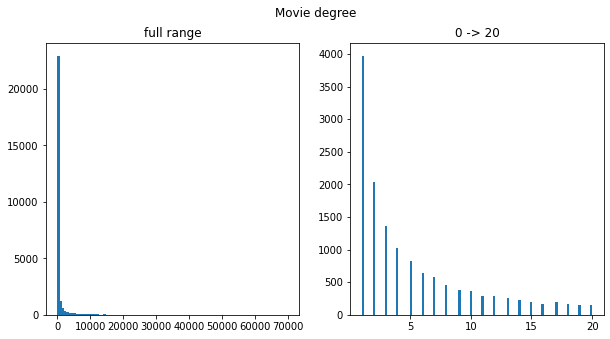

In [ ]:
m = graph.colFormat.shape[1]
degreeDist = [graph.colFormat[:,i].nnz for i in range(1,m)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Movie degree')
ax1.hist(degreeDist, bins= 100, range= (0, 70000), log=False)
ax1.set_title('full range')
ax2.hist(degreeDist, bins = 100, range=(1,20), log= False)
ax2.set_title('0 -> 20')
plt.show()

weight of the first degrees 0.6706652126499455


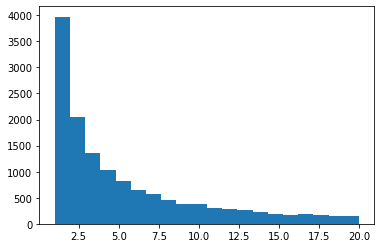

In [ ]:
count = plt.hist(degreeDist, bins = 20, range=(1,20), log= False)[0]

print('weight of the first degrees', np.sum(count[[0,1,2,3,4]]) /np.sum(count))

**Remarks** : 

When predicting the class of an edge (user, movie) we assume we have gathered underlying data on the user or on the movie during the fit on the training data.
However, because a lot of movies are seen once or twice, with a non negligible probability, we might have to classify an edge for which the movie has not been seen.

**Solution** :

A way to tackle this problem is to threshold the data set by the movie degrees.

In [ ]:
graph.adjency.row
graph.adjency.col
graph.edges

## Features

In [17]:
import pandas as pd
import numpy as np

In [16]:
userMovieData = pd.read_csv('userMovieData.csv')

In [12]:
dfByUser = userMovieData.groupby('userId')
dfByMovie = userMovieData.groupby('movieId')

In [8]:
class NodeFeatures:
    '''See https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html
    '''  
    Genres = ['Action', 'Adventure', 'Animation', 
        "Children", 'Comedy', 'Crime', 'Documentary', 'Drama',
        'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
        'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)']
    
    mn = 1900 # small = 1900, heavy = 1891
    mx = 2015 # keep this one
    Years = ["{0} - {1}".format(i, i + 9) for i in range(mn, mx, 10)] #caution

    # -- user

    @staticmethod 
    def user_mean(dfByUser:pd.DataFrame):
        return dfByUser['rating'].agg(np.mean)
    
    @staticmethod
    def user_std(dfByUser:pd.DataFrame):
        return dfByUser['rating'].agg(np.std)
    
    @staticmethod
    def user_degree(dfByUser:pd.DataFrame):
        return dfByUser.size()
      
    @staticmethod 
    def user_corr_movie(dfByUser:pd.DataFrame):
        # has no interest, but feasible
        return dfByUser[['userId', 'movieId']].corr()['userId'][:, 'movieId']
    
    @staticmethod
    def user_tag(dfByUser:pd.DataFrame):
        return dfByUser['tag'].count()
    
    # -- movie

    @staticmethod 
    def movie_mean(dfByMovie:pd.DataFrame):
        return dfByMovie['rating'].agg(np.mean)
    
    @staticmethod
    def movie_std(dfByMovie: pd.DataFrame):
        return dfByMovie['rating'].std(ddof=0)
    
    @staticmethod
    def movie_degree(dfByMovie: pd.DataFrame):
        return dfByMovie.size()
    
    @staticmethod
    def movie_tag(dfByMovie: pd.DataFrame):
        return dfByMovie['tag'].count()

    @classmethod
    def movie_genre(cls, dfByMovie: pd.DataFrame):
        return dfByMovie[cls.Genres].first()
    
    @classmethod
    def movie_year(cls, dfByMovie: pd.DataFrame):
        return dfByMovie[cls.Years].first()
    
    
    # -- graph

    @staticmethod
    def f():
      pass
    


In [14]:
print(NodeFeatures.movie_year(dfByMovie).head(5))
print(NodeFeatures.movie_genre(dfByMovie).head(5))

         1900 - 1909  1910 - 1919  ...  2000 - 2009  2010 - 2019
movieId                            ...                          
1                  0            0  ...            0            0
2                  0            0  ...            0            0
3                  0            0  ...            0            0
4                  0            0  ...            0            0
5                  0            0  ...            0            0

[5 rows x 12 columns]
         Action  Adventure  Animation  ...  War  Western  (no genres listed)
movieId                                ...                                  
1             0          1          1  ...    0        0                   0
2             0          1          0  ...    0        0                   0
3             0          0          0  ...    0        0                   0
4             0          0          0  ...    0        0                   0
5             0          0          0  ...    0        0    

## Training Classifiers

#### Abstract RecSystem

In [436]:
'''
Recommender systems abstract classes.
Inspired by sklearn _base.py
'''
#%% Modules
#standard
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd

#%% Trivial Recommandation System
class _RecSystem(ABC):
    '''
    Abstract class for recommender systems.
    '''
    def __init__(self):
        pass

    @abstractmethod
    def fit(self, edges):
        pass

    @abstractmethod
    def predict(self, edges, *args):
        pass
    pass



class _Clf(_RecSystem):
    '''
    Classifier recommendation system
    '''
    def __init__(self, df, adj, likeThr):
        super().__init__()
        self.df = df
        self.adj = adj
        self.likeThr = likeThr
        pass

    def _get_feature_matrix(self, edges):
        '''
        '''
        df = self.df.iloc[edges]
        featFncts = self.featFncts

        dfByUser = df.groupby('userId')
        dfByMovie = df.groupby('movieId')

        X = pd.DataFrame() 
        X['userId'] = df['userId']
        X['movieId'] = df['movieId']
        X_u = pd.DataFrame(index= df['userId'].drop_duplicates().sort_values())
        X_m = pd.DataFrame(index= df['movieId'].drop_duplicates().sort_values())

        k = 0
        for featFnct in featFncts['user']:
            dfU= featFnct(dfByUser)
            if isinstance(dfU, pd.Series):
              X_u['xu'+str(k)] = dfU
              k+=1
            
            if isinstance(dfU, pd.DataFrame):
              # comes from ohe
              colU = X_u.columns
              for col in colU:
                X_u['xu'+str(k)] = dfU[col]
                k += 1
        k = 0
        for featFnct in featFncts['movie']:
            dfM= featFnct(dfByMovie)
            if isinstance(dfM, pd.Series):
              X_m['xm'+str(k)] = dfM
              k+=1
            
            if isinstance(dfM, pd.DataFrame):
              # comes from ohe
              colM = dfM.columns
              for col in colM:
                X_m['xm'+str(k)] = dfM[col]
                k += 1
        
        xTrain = X.merge(X_u, on='userId', how='left').merge(X_m, on='movieId', how='left')
        xTrain.index = df.index
        return xTrain, X_u, X_m

    def _get_labels(self, edges):
        return (self.df['rating'].iloc[edges] > self.likeThr).astype('uint8')

    def _get_known_edges(self, edges):
        ''' gets the edges for which we have data for both the user and the movie
        '''
        X_u = self.X_u
        X_m = self.X_m
        xTrain = self.xTrain
        d = np.column_stack((self.adj.row, self.adj.col))[edges]
        data = np.zeros((d.shape[0],), dtype=bool)

        unicU, invU  = np.unique(self.adj.row[edges], return_inverse=True)
        _, _, commU = np.intersect1d(self.xTrain['userId'], unicU, assume_unique=False, return_indices=True)
        maskU = np.zeros_like(unicU, dtype= bool)
        maskU[commU] = True
        knownEdgeUser = np.where(maskU[invU])

        unicM, invM  = np.unique(self.adj.col[edges], return_inverse=True)
        _, _, commM = np.intersect1d(self.xTrain['movieId'], unicM, assume_unique=False, return_indices=True)
        maskM = np.zeros_like(unicM, dtype= bool)
        maskM[commM] = True
        knownEdgeMovie = np.where(maskM[invM])
        
        # index in xTrain
        knownE = edges[np.intersect1d(knownEdgeUser, knownEdgeMovie, assume_unique=True)]

        knownU = self.adj.row[knownE]
        knownM = self.adj.col[knownE]

        # -- getting data on user
        unicU = np.unique(knownU)
        _,commX_u, _ = np.intersect1d(X_u.index, unicU, assume_unique=True, return_indices=True)
        X_uT = X_u.iloc[commX_u] 

        # -- getting data on movies
        unicM = np.unique(knownM)
        _,commX_m, _ = np.intersect1d(X_m.index, unicM, assume_unique=True, return_indices=True)
        X_mT = X_m.iloc[commX_m]

        # -- Building the matrix
        X = pd.DataFrame({'userId': knownU, 'movieId': knownM})
        xTestKnown = X.merge(X_uT, on='userId', how='left').merge(X_mT, on='movieId', how='left')
        xTestKnown.index = knownE
        unknownE = np.setdiff1d(edges, knownE, assume_unique=True)
        yTestUnknown = pd.Series(np.random.randint(2, size= len(unknownE)), index= unknownE)

        return xTestKnown, yTestUnknown

    @abstractmethod
    def _predict_known(self, xTestKnown: pd.DataFrame):
        '''Returns
          -------
          pd.DataFrame
        '''
        pass


    def predict(self, edges):
        '''predicts if the user likes the movie, without looking at the score of the edge.
        
        Parameters
        -------
            edges : list
                edges of the sub-graph you consider for the prediction.
        Returns
        -------
            pred: np.array of shape (nEdges,)
                containing the predictions (0 or 1) in the same order
        '''

        xTestKnown, yTestUnknown = self._get_known_edges(edges)

        # -- prediction
        yTestKnown = self._predict_known(xTestKnown)

        # -- check if it is a partition
        assert len(set(yTestKnown.index).intersection(yTestUnknown.index)) ==0
        assert len(set(yTestKnown.index).union(yTestUnknown.index)) == len(edges)
        yPred = pd.Series(np.zeros_like(edges, dtype='uint8'), index=edges)
        yPred[yTestKnown.index] = yTestKnown.astype('uint8')
        yPred[yTestUnknown.index] = yTestUnknown.astype('uint8')
        print('prop of classes chosen at random', len(yTestUnknown)/len(yPred))
        return yPred
    pass

### Linear Clf

#### **Trivial**

In [498]:
'''
Trivial Recommender System
'''

#%% Modules
# standard
import numpy as np

#%% Trivial Recommendation System
class TrivialClf(_Clf):
    def __init__(self, df, adj, likeThr):
        self.set_featFncts()
        super().__init__(df,adj, likeThr)
        pass

    def set_featFncts(self):
        # -- setting feature functions
        self.featFncts = {'user': [NodeFeatures.user_mean],
              'movie': [NodeFeatures.movie_mean]
              }

    def fit(self, edges):
        '''Nothing parameter to fit for this clf
        '''
        self.xTrain, self.X_u, self.X_m = self._get_feature_matrix(edges)
        pass

    def _predict_known(self, xTestKnown):
        #return xTestKnown['xu0'] < xTestKnown['xm0']
        return xTestKnown['xm0'] > self.likeThr


In [491]:
def set_featFncts(self):
    # -- adding movie degree to see over how many nodes the mean is taken
    self.featFncts = {'user': [NodeFeatures.user_mean],
          'movie': [NodeFeatures.movie_mean, NodeFeatures.movie_degree]
          }
TrivialClf.set_featFncts= set_featFncts

In [492]:
likeThr = 2.9
clf = TrivialClf(userMovieData, graph.adjency, likeThr = likeThr)

In [493]:
clf.fit(trainEdges)

In [494]:
yPred = clf.predict(testEdges)
yTrue = clf._get_labels(testEdges)

prop of classes chosen at random 0.04300826446280992


In [495]:
size = 10
sample = rd.choice(range(len(testEdges)), size=size)
print(yPred.iloc[sample])
print(yTrue.iloc[sample])

17891    1
66319    1
12759    1
45283    1
49323    0
34687    1
15427    1
21966    0
11445    1
83169    1
dtype: uint8
17891    1
66319    1
12759    1
45283    0
49323    1
34687    1
15427    1
21966    1
11445    1
83169    1
Name: rating, dtype: uint8


In [496]:
print(clf._get_feature_matrix(testEdges[sample])[0])

       userId  movieId  xu0  xm0  xm1
17891     111   179211  3.5  3.5    1
66319     427     5107  3.0  3.0    1
12759      82      380  4.0  4.0    1
45283     298    85022  2.5  2.5    1
49323     318     7228  3.0  3.0    1
34687     232    65216  4.0  4.0    1
15427     100     4246  4.5  4.5    1
21966     143   103606  4.0  4.0    1
11445      68    63131  4.5  4.5    1
83169     526   176413  4.5  4.5    1


#### Tests (using trivial Clf)

In [208]:
likeThr = 3.7
clf = TrivialClf(userMovieData, graph.adjency, likeThr = likeThr)

In [209]:
# -- edge / adj correspondancy
edgeIdx = 900
graph.adjency.row[edgeIdx], graph.adjency.col[edgeIdx]

(7, 1219)

In [210]:
userMovieData.iloc[edgeIdx-1:edgeIdx+2]

,Unnamed: 0,userId,movieId,rating,timestamp_rating,tag,timestamp_tag,1900 - 1909,1910 - 1919,1920 - 1929,1930 - 1939,1940 - 1949,1950 - 1959,1960 - 1969,1970 - 1979,1980 - 1989,1990 - 1999,2000 - 2009,2010 - 2019,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed)
899,899,7,1210,4.0,1106635965,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
900,900,7,1219,5.0,1106635496,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
901,901,7,1220,4.5,1106635464,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [211]:
# -- _get_labels
print(clf._get_labels(graph.edges[501:512]))

501    1
502    1
503    0
504    0
505    1
506    0
507    1
508    0
509    0
510    0
511    1
Name: rating, dtype: uint8


In [212]:
userMovieData.iloc[graph.edges[501:512]]

,Unnamed: 0,userId,movieId,rating,timestamp_rating,tag,timestamp_tag,1900 - 1909,1910 - 1919,1920 - 1929,1930 - 1939,1940 - 1949,1950 - 1959,1960 - 1969,1970 - 1979,1980 - 1989,1990 - 1999,2000 - 2009,2010 - 2019,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed)
501,501,4,4239,5.0,986848685,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
502,502,4,4246,4.0,1007574542,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
503,503,4,4252,3.0,1007569465,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
504,504,4,4260,2.0,1007569424,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
505,505,4,4273,4.0,1007574470,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
506,506,4,4308,1.0,1007569465,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
507,507,4,4347,4.0,1007569586,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
508,508,4,4381,3.0,1007574509,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
509,509,4,4641,1.0,1007569586,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
510,510,4,4741,3.0,1007574532,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [213]:
# -- _get_known_edges
clf.fit(graph.edges[990:1000])
print('true users', clf.adj.row[990:1000])
print('true movies', clf.adj.col[990:1000])
print('first edge', clf.adj.tocsr()[clf.adj.row[990],clf.adj.col[990]])

print('X_u', clf.X_u)
print('X_m', clf.X_m)
print('xTrain', clf.xTrain)

true users [7 7 7 7 7 7 7 7 7 7]
true movies [ 8957  8958  8961  8965  8970  8972  8984 27741 30812 30816]
first edge 990
X_u         xu0
userId     
7       3.0
X_m          xm0
movieId     
8957     4.0
8958     3.5
8961     4.0
8965     1.0
8970     2.5
8972     2.5
8984     4.0
27741    3.0
30812    3.5
30816    2.0
xTrain      userId  movieId  xu0  xm0
990       7     8957  3.0  4.0
991       7     8958  3.0  3.5
992       7     8961  3.0  4.0
993       7     8965  3.0  1.0
994       7     8970  3.0  2.5
995       7     8972  3.0  2.5
996       7     8984  3.0  4.0
997       7    27741  3.0  3.0
998       7    30812  3.0  3.5
999       7    30816  3.0  2.0


In [214]:
clf.xTrain

,userId,movieId,xu0,xm0
990,7,8957,3.0,4.0
991,7,8958,3.0,3.5
992,7,8961,3.0,4.0
993,7,8965,3.0,1.0
994,7,8970,3.0,2.5
995,7,8972,3.0,2.5
996,7,8984,3.0,4.0
997,7,27741,3.0,3.0
998,7,30812,3.0,3.5
999,7,30816,3.0,2.0


In [215]:
xTestKnown, yTestUnknown = clf._get_known_edges(graph.edges[::2])
print(xTestKnown)
print(yTestUnknown)

     userId  movieId  xu0  xm0
990       7     8957  3.0  4.0
992       7     8961  3.0  4.0
994       7     8970  3.0  2.5
996       7     8984  3.0  4.0
998       7    30812  3.0  3.5
0         1
2         1
4         0
6         0
8         0
         ..
100826    0
100828    0
100830    1
100832    1
100834    1
Length: 50413, dtype: int64


In [216]:
# More difficult
clf.fit(graph.edges[0:1001:50])
print(graph.edges[900:1001:5])
print(clf._get_known_edges(graph.edges[900:1001:5])[0])

[ 900  905  910  915  920  925  930  935  940  945  950  955  960  965
  970  975  980  985  990  995 1000]
      userId  movieId       xu0  xm0
900        7     1219  4.333333  5.0
950        7     4993  4.333333  4.5
1000       7    31878  4.333333  3.5


In [217]:
# final test
trainEdges, testEdges = graph.train_test_split(0.1)
clf.fit(trainEdges)

In [219]:
print(clf._get_known_edges(testEdges)[0])
print('prop', clf._get_known_edges(testEdges)[0].shape[0]/len(testEdges))

        userId  movieId       xu0       xm0
28           1      527  4.355450  4.185864
52           1     1025  4.355450  3.500000
75           1     1214  4.355450  3.984496
81           1     1240  4.355450  3.907895
83           1     1258  4.355450  4.098958
...        ...      ...       ...       ...
100761     610   134368  3.694087  3.576923
100777     610   138210  3.694087  3.250000
100785     610   140247  3.694087  3.166667
100812     610   156726  3.694087  1.750000
100816     610   158872  3.694087  3.666667

[9709 rows x 4 columns]
prop 0.9629078647228008


In [227]:
# -- check good index
print(clf.adj.row[graph.edges[100761]], clf.adj.col[graph.edges[100761]])

610 134368


In [237]:
# -- check good data
print(clf.X_u[clf.X_u.index == 610])
print(clf.X_m[clf.X_m.index == 134368])

             xu0
userId          
610     3.694087
              xm0
movieId          
134368   3.576923


#### **Logistic Regression**

In [460]:
'''
Logistic Regression
'''
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

class LogRegClf(_Clf):
    def __init__(self, df, adj, likeThr=3.4, C0= 1e0, balanced= True):
        self.set_featFncts()
        super().__init__(df,adj, likeThr)
        self.C0 = C0
        self.class_weight = 'balanced' if balanced else None
        pass

    def set_featFncts(self):
        # -- setting feature functions
        self.featFncts = {'user': [NodeFeatures.user_mean],
              'movie': [NodeFeatures.movie_mean]
              }
    
    def _set_scaler(self, X):
        scaler = StandardScaler()
        scaler.fit(X)

        self.scaler = scaler
        pass
    
    def _process(self, X):
        '''data preprocessing for the clf. Scaler should have been set
        '''
        scaler = self.scaler
        return scaler.transform(X)
        

    def fit(self, edges):
        self.xTrain, self.X_u, self.X_m = self._get_feature_matrix(edges)
        self.yTrain = self._get_labels(edges)

        self.clf = LogisticRegression(C = self.C0, class_weight=self.class_weight)
        xTrainPre = self.xTrain.drop(columns= ['userId', 'movieId'])
        self._set_scaler(xTrainPre)
        self.clf.fit(self._process(xTrainPre), self.yTrain)
        pass

    def _predict_known(self, xTestKnown):
        print(xTestKnown.head(10))
        xTestKnownPre = self._process(xTestKnown.drop(columns= ['userId', 'movieId']))
        return pd.Series(self.clf.predict(xTestKnownPre), index= xTestKnown.index)


##### Basic Features

In [461]:
def set_featFncts(self):
    # -- setting feature functions
    self.featFncts = {'user': [NodeFeatures.user_mean],
          'movie': [NodeFeatures.movie_mean]
          }
    pass

LogRegClf.set_featFncts = set_featFncts

In [462]:
# -- Parameters
likeThr = 3.9
C0 = 1e0
balanced = True

# -- Def
clf = LogRegClf(userMovieData, graph.adjency, likeThr = likeThr, balanced = balanced)

In [463]:
clf.fit(trainEdges)
yPred = clf.predict(testEdges)
yTrue = clf._get_labels(testEdges)

    userId  movieId       xu0       xm0
0        1        1  4.398844  3.948630
4        1       50  4.398844  4.274306
12       1      223  4.398844  3.789855
22       1      367  4.398844  3.138095
29       1      543  4.398844  3.333333
31       1      553  4.398844  3.819149
34       1      593  4.398844  4.191919
40       1      733  4.398844  3.672619
41       1      736  4.398844  3.373626
45       1      923  4.398844  4.011111
prop of classes chosen at random 0.04300826446280992


In [464]:
# -- Training score
clf.clf.score(clf.xTrain.drop(columns={'userId','movieId'}), clf.yTrain)

0.48180942396509224

In [465]:
# -- Test Score
print(classification_report(yPred, yTrue))

              precision    recall  f1-score   support

           0       0.67      0.72      0.70     14657
           1       0.72      0.67      0.69     15593

    accuracy                           0.69     30250
   macro avg       0.69      0.69      0.69     30250
weighted avg       0.70      0.69      0.69     30250



##### More Features

In [466]:
def set_featFncts(self):
    # -- setting feature functions
    self.featFncts = {'user': [NodeFeatures.user_mean, 
                               NodeFeatures.user_std,
                               NodeFeatures.user_degree,
                               NodeFeatures.user_tag],
                      'movie': [NodeFeatures.movie_mean,
                                NodeFeatures.movie_std,
                                NodeFeatures.movie_tag,
                                NodeFeatures.movie_degree,
                                NodeFeatures.movie_genre,
                                NodeFeatures.movie_year]}
    pass

LogRegClf.set_featFncts = set_featFncts

In [467]:
# -- Parameters
likeThr = 3.9
C0 = 1e0
balanced = True

# -- Def
clf = LogRegClf(userMovieData, graph.adjency, likeThr = likeThr, balanced = balanced)

In [468]:
clf.fit(trainEdges)
yPred = clf.predict(testEdges)
yTrue = clf._get_labels(testEdges)

    userId  movieId       xu0       xu1  xu2  ...  xm31  xm32  xm33  xm34  xm35
0        1        1  4.398844  0.775646  173  ...     0     0     1     0     0
4        1       50  4.398844  0.775646  173  ...     0     0     1     0     0
12       1      223  4.398844  0.775646  173  ...     0     0     1     0     0
22       1      367  4.398844  0.775646  173  ...     0     0     1     0     0
29       1      543  4.398844  0.775646  173  ...     0     0     1     0     0
31       1      553  4.398844  0.775646  173  ...     0     0     1     0     0
34       1      593  4.398844  0.775646  173  ...     0     0     1     0     0
40       1      733  4.398844  0.775646  173  ...     0     0     1     0     0
41       1      736  4.398844  0.775646  173  ...     0     0     1     0     0
45       1      923  4.398844  0.775646  173  ...     0     0     0     0     0

[10 rows x 42 columns]
prop of classes chosen at random 0.04300826446280992


In [469]:
print(yTrue[:20])

0     1
4     1
12    0
22    1
29    1
31    1
34    1
40    1
41    0
45    1
49    0
53    1
57    1
62    1
67    1
73    1
75    1
76    0
84    1
88    1
Name: rating, dtype: uint8


In [470]:
# -- Training set
print(classification_report(clf.clf.predict(clf._process(clf.xTrain.drop(columns= ['userId', 'movieId']))), clf.yTrain))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74     34070
           1       0.77      0.72      0.74     36516

    accuracy                           0.74     70586
   macro avg       0.74      0.74      0.74     70586
weighted avg       0.74      0.74      0.74     70586



In [471]:
# -- Test set
print(classification_report(yPred, yTrue))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69     14497
           1       0.72      0.67      0.69     15753

    accuracy                           0.69     30250
   macro avg       0.69      0.69      0.69     30250
weighted avg       0.70      0.69      0.69     30250



##### Correlation to labels

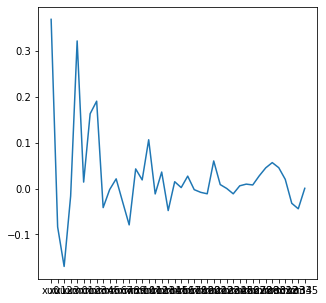

In [472]:
import matplotlib.pyplot as plt
xTestKnown, _ = clf._get_known_edges(testEdges)
plt.figure(figsize=(5,5))
plt.plot(xTestKnown.drop(columns={'userId','movieId'}).corrwith(yTrue))
plt.show()

### Non Linear Clf

#### **Tree** 

In [473]:
'''
Tree Classifier
'''
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

class TreeClf(_Clf):
    def __init__(self, df, adj, likeThr=3.4, balanced= True,
                 max_depth= None, min_samples_split= 2, min_samples_leaf= 1):
        self.set_featFncts()
        super().__init__(df,adj, likeThr)
        self.class_weight = 'balanced' if balanced else None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        pass

    def set_featFncts(self):
        # -- setting feature functions
        self.featFncts = {'user': [NodeFeatures.user_mean],
              'movie': [NodeFeatures.movie_mean]
              }
    
    def _set_scaler(self, X):
        scaler = StandardScaler()
        scaler.fit(X)

        self.scaler = scaler
        pass
    
    def _process(self, X):
        '''data preprocessing for the clf. Scaler should have been set
        '''
        scaler = self.scaler
        return scaler.transform(X)
        

    def fit(self, edges):
        self.xTrain, self.X_u, self.X_m = self._get_feature_matrix(edges)
        self.yTrain = self._get_labels(edges)

        self.clf = DecisionTreeClassifier(class_weight=self.class_weight, 
                                          max_depth=self.max_depth,
                                          min_samples_split = self.min_samples_split,
                                          min_samples_leaf= self.min_samples_leaf)
        xTrainPre = self.xTrain.drop(columns= ['userId', 'movieId'])
        self._set_scaler(xTrainPre)
        self.clf.fit(self._process(xTrainPre), self.yTrain)
        pass

    def _predict_known(self, xTestKnown):
        xTestKnownPre = self._process(xTestKnown.drop(columns= ['userId', 'movieId']))
        return pd.Series(self.clf.predict(xTestKnownPre), index= xTestKnown.index)

In [474]:
def set_featFncts(self):
    # -- setting feature functions
    self.featFncts = {'user': [NodeFeatures.user_mean, 
                               NodeFeatures.user_std,
                               NodeFeatures.user_degree,
                               NodeFeatures.user_tag],
                      'movie': [NodeFeatures.movie_mean,
                                NodeFeatures.movie_std,
                                NodeFeatures.movie_tag,
                                NodeFeatures.movie_degree,
                                NodeFeatures.movie_genre,
                                NodeFeatures.movie_year]}
    pass

TreeClf.set_featFncts = set_featFncts

In [475]:
# -- Parameters (default value overfits the training data)
likeThr = 3.4
balanced = True
max_depth = 5
min_samples_split = 2
min_samples_leaf = 10 

# -- Def
clf = TreeClf(userMovieData, graph.adjency, likeThr = likeThr, 
              balanced = balanced, min_samples_leaf= min_samples_leaf)

In [476]:
clf.fit(trainEdges)
yPred = clf.predict(testEdges)
yTrue = clf._get_labels(testEdges)

prop of classes chosen at random 0.04300826446280992


In [477]:
# -- Training set
print(classification_report(clf.clf.predict(clf._process(clf.xTrain.drop(columns= ['userId', 'movieId']))), clf.yTrain))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79     31452
           1       0.81      0.90      0.85     39134

    accuracy                           0.83     70586
   macro avg       0.83      0.82      0.82     70586
weighted avg       0.83      0.83      0.83     70586



In [478]:
# -- Test set
print(classification_report(yPred, yTrue))

              precision    recall  f1-score   support

           0       0.66      0.57      0.61     13549
           1       0.69      0.76      0.72     16701

    accuracy                           0.67     30250
   macro avg       0.67      0.66      0.67     30250
weighted avg       0.67      0.67      0.67     30250



#### **Gradient Boosting**

In [479]:
from sklearn.ensemble import GradientBoostingClassifier

In [480]:
class GradientBoostingClf(_Clf):
    def __init__(self, df, adj, likeThr=3.4, max_depth= None, max_features= None,
                 lr= 0.1, min_samples_split= 2, min_samples_leaf= 1, n_estimators=100):
        self.set_featFncts()
        super().__init__(df,adj, likeThr)
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.lr = lr
        self.n_estimators = n_estimators
        self.max_features = max_features
        pass

    def set_featFncts(self):
        # -- setting feature functions
        self.featFncts = {'user': [NodeFeatures.user_mean],
              'movie': [NodeFeatures.movie_mean]
              }
    
    def _set_scaler(self, X):
        scaler = StandardScaler()
        scaler.fit(X)

        self.scaler = scaler
        pass
    
    def _process(self, X):
        '''data preprocessing for the clf. Scaler should have been set
        '''
        scaler = self.scaler
        return scaler.transform(X)
        

    def fit(self, edges):
        self.xTrain, self.X_u, self.X_m = self._get_feature_matrix(edges)
        self.yTrain = self._get_labels(edges)

        self.clf = clf = GradientBoostingClassifier(n_estimators=self.n_estimators, 
                                                    learning_rate=self.lr,
                                                    max_depth=self.max_depth,
                                                    max_features = self.max_features,
                                                    min_samples_split= self.min_samples_split,
                                                    min_samples_leaf= self.min_samples_leaf)
        xTrainPre = self.xTrain.drop(columns= ['userId', 'movieId'])
        self._set_scaler(xTrainPre)
        self.clf.fit(self._process(xTrainPre), self.yTrain)
        pass

    def _predict_known(self, xTestKnown):
        xTestKnownPre = self._process(xTestKnown.drop(columns= ['userId', 'movieId']))
        return pd.Series(self.clf.predict(xTestKnownPre), index= xTestKnown.index)

In [481]:
def set_featFncts(self):
    # -- setting feature functions
    self.featFncts = {'user': [NodeFeatures.user_mean, 
                               NodeFeatures.user_std,
                               NodeFeatures.user_degree,
                               NodeFeatures.user_tag],
                      'movie': [NodeFeatures.movie_mean,
                                NodeFeatures.movie_std,
                                NodeFeatures.movie_tag,
                                NodeFeatures.movie_degree,
                                NodeFeatures.movie_genre,
                                NodeFeatures.movie_year]}
    pass

GradientBoostingClf.set_featFncts = set_featFncts

In [482]:
# -- Parameters
likeThr = 3.4

lr = 1e-2
n_estimators = 1000
max_depth = 3
max_features = 10
min_samples_split = 2
min_samples_leaf = 5

# -- Def
clf = GradientBoostingClf(userMovieData, graph.adjency, likeThr = likeThr, 
                          lr= 1e-1, min_samples_leaf= min_samples_leaf, 
                          min_samples_split= min_samples_split, max_depth= max_depth,
                          max_features= max_features, n_estimators= n_estimators)

In [483]:
clf.fit(trainEdges)
yPred = clf.predict(testEdges)
yTrue = clf._get_labels(testEdges)

prop of classes chosen at random 0.04300826446280992


In [484]:
# -- Training set
print(classification_report(clf.clf.predict(clf._process(clf.xTrain.drop(columns= ['userId', 'movieId']))), clf.yTrain))

              precision    recall  f1-score   support

           0       0.66      0.77      0.71     23315
           1       0.88      0.80      0.84     47271

    accuracy                           0.79     70586
   macro avg       0.77      0.79      0.78     70586
weighted avg       0.81      0.79      0.80     70586



In [485]:
# -- Test set
print(classification_report(yPred, yTrue))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62     10049
           1       0.82      0.75      0.78     20201

    accuracy                           0.72     30250
   macro avg       0.69      0.71      0.70     30250
weighted avg       0.74      0.72      0.73     30250



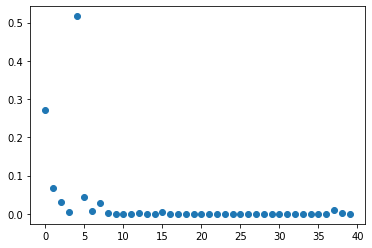

In [486]:
plt.scatter(range(len(clf.clf.feature_importances_)),clf.clf.feature_importances_)